# Analysis of size of control samples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np 
import milopy
import scipy
import warnings

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [5]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_ctrl_size/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [6]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [9]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [34]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [35]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette)
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette)
}

### Experiment set-up

```bash
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/scripts

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/

for p in $(cat /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt); do
    for d in ACR AR CR; do
        echo "python run_oor_design.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${p} ${d} --outpath ${outdir}" | \
            bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
    done
done

## To merge results

awk '(NR == 1) || (FNR > 1)' ${outdir}/*/ctrl_size_analysis_nquery7/*/*_results.csv > ${outdir}/ctrl_size_nquery7_results.csv
```


### Parse results 

In [137]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'

res_all_df = pd.read_csv(outdir + 'ctrl_size_nquery7_results.csv', index_col=0)
old_code = True

In [138]:
## Fix FP/FN (bug in old code)
if old_code:
    res_all_df.columns = ['TP', 'FN', 'FP', 'TN', 'TPR', 'FPR', 'FDR', 'AUPRC', 'no_skill_thresh',
           'OOR_state', 'n_ctrls', 'random_seed', 'ref_design']

    res_all_df["TPR"] = res_all_df["TP"] / (res_all_df["TP"] + res_all_df["FN"])
    res_all_df["FPR"] = res_all_df["FP"] / (res_all_df["FP"] + res_all_df["TN"])
    res_all_df["FDR"] = res_all_df["FP"] / (res_all_df["FP"] + res_all_df["TP"])

In [139]:
# cts = pd.read_csv('/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt', header=None)[0]

# missing_cts = cts[~cts.isin(res_all_df.OOR_state.unique())].values

# missing_cts
# [print(outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022') for ct in missing_cts]

In [140]:
res_all_df.random_seed.unique()

array([12345, 12346, 12347])

In [141]:
%%R -i res_all_df
head(res_all_df)

  TP FN FP  TN       TPR        FPR       FDR     AUPRC no_skill_thresh
1  6  4  0 613 0.6000000 0.00000000 0.0000000 0.6328967      0.01605136
2  9  1 70 576 0.9000000 0.10835913 0.8860759 0.2831901      0.01524390
3  4  3  0 549 0.5714286 0.00000000 0.0000000 0.5878971      0.01258993
4 10  5 23 559 0.6666667 0.03951890 0.6969697 0.3780535      0.02512563
5  7  5  0 629 0.5833333 0.00000000 0.0000000 0.6511312      0.01872075
6  5  2 59 598 0.7142857 0.08980213 0.9218750 0.1560280      0.01054217
                        OOR_state n_ctrls random_seed ref_design
1 CD14_low_CD16_positive_monocyte      10       12345        ACR
2 CD14_low_CD16_positive_monocyte      10       12345         CR
3 CD14_low_CD16_positive_monocyte      10       12346        ACR
4 CD14_low_CD16_positive_monocyte      10       12346         CR
5 CD14_low_CD16_positive_monocyte      10       12347        ACR
6 CD14_low_CD16_positive_monocyte      10       12347         CR


`summarise()` has grouped output by 'ref_design', 'OOR_state'. You can override using the `.groups` argument.


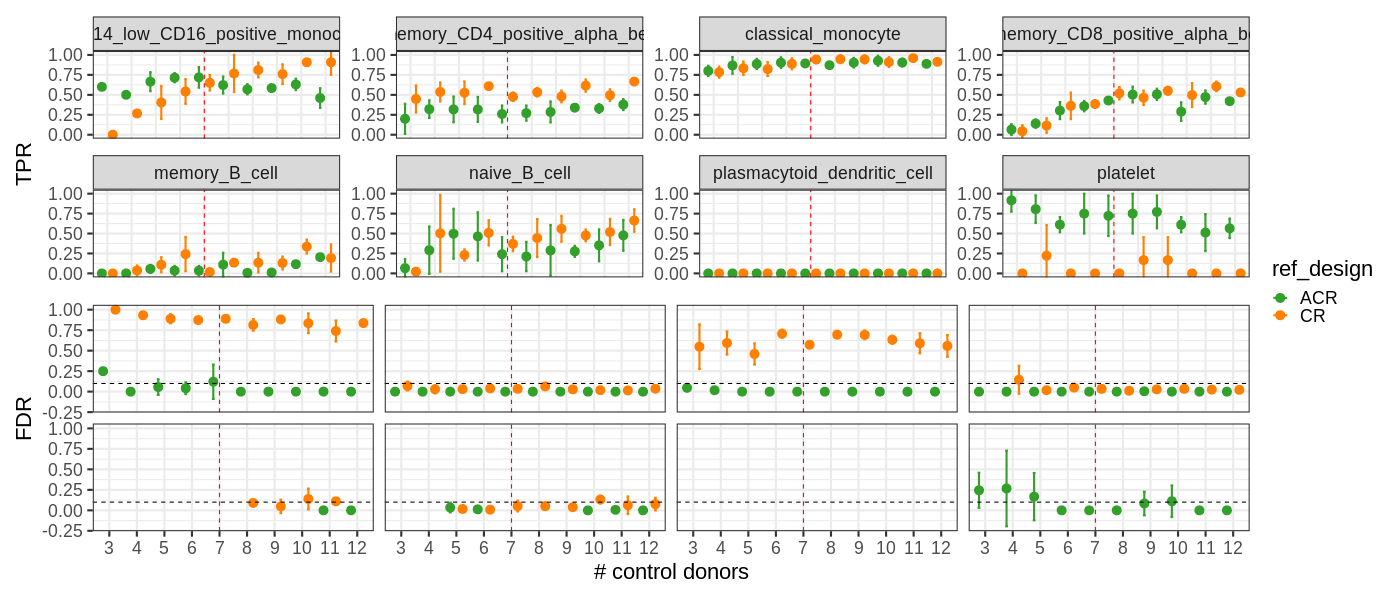

In [163]:
%%R  -h 600 -w 1400 -i figdir

# ct_labeller <- c(
#      'natural_killer_cell' = 'NK cells',
#      'classical_monocyte' = 'Classical monocyte',
#     'central_memory_CD4_positive_alpha_beta_T_cell' = 'CM CD4+ T cells',
#     'effector_memory_CD8_positive_alpha_beta_T_cell' = 'EM CD8+ T cells'
# )

pl_df <- res_all_df %>%
    filter(ref_design != 'joint_PC') %>%
    group_by(ref_design, OOR_state, n_ctrls) %>%
    summarise(mean_TPR=mean(TPR), mean_FPR=mean(FPR), mean_FDR=mean(FDR), mean_AUPRC=mean(AUPRC),
              sd_TPR = sd(TPR),   sd_FPR = sd(FPR),   sd_FDR = sd(FDR),   sd_AUPRC=sd(AUPRC))
    
tpr_pl <- pl_df %>%
    mutate(ymax = mean_TPR + sd_TPR, ymin = mean_TPR - sd_TPR) %>%
    ggplot(aes(as.factor(n_ctrls), mean_TPR, color=ref_design)) +
    geom_point(size=4, position=position_dodge(width=0.9)) +
    geom_errorbar(aes(ymin=mean_TPR - sd_TPR, ymax = mean_TPR + sd_TPR), 
                  size=1, width=.2, position=position_dodge(width=0.9)) +
    # geom_line(size=1) +
    scale_color_design() +
    geom_vline(xintercept=max(pl_df$n_ctrls) - 7, linetype=2, color='red') +
    theme_bw(base_size=22) +
    coord_cartesian(ylim = c(0,1)) +
    facet_wrap(OOR_state~.,  ncol=4, 
#                labeller = labeller(OOR_state = ct_labeller), 
               scales='free') +
    xlab('# control donors') + ylab("TPR")

fpr_pl <-pl_df %>%
    mutate(ymax = mean_FDR + sd_FDR, ymin = mean_FDR - sd_FDR) %>%
    ggplot(aes(as.factor(n_ctrls), mean_FDR, color=ref_design)) +
    geom_point(size=4, position=position_dodge(width=0.9)) +
    geom_errorbar(aes(ymin=ymin, ymax = ymax), 
                  size=1, width=.2, position=position_dodge(width=0.9)) +
    scale_color_design() +
    theme_bw(base_size=22) +
#     coord_cartesian(ylim = c(0,1)) +
    geom_vline(xintercept=max(pl_df$n_ctrls) - 7, linetype=2, color='red') +
    geom_hline(yintercept=0.1, linetype=2) +
    facet_wrap(OOR_state~.,  ncol=4, 
#                labeller = labeller(OOR_state = ct_labeller), 
              ) +
    xlab('# control donors') + ylab("FDR")

    
((tpr_pl + remove_x_axis()) / 
 fpr_pl + theme(strip.background = element_blank(), strip.text = element_blank())
) +
plot_layout(guides='collect') 

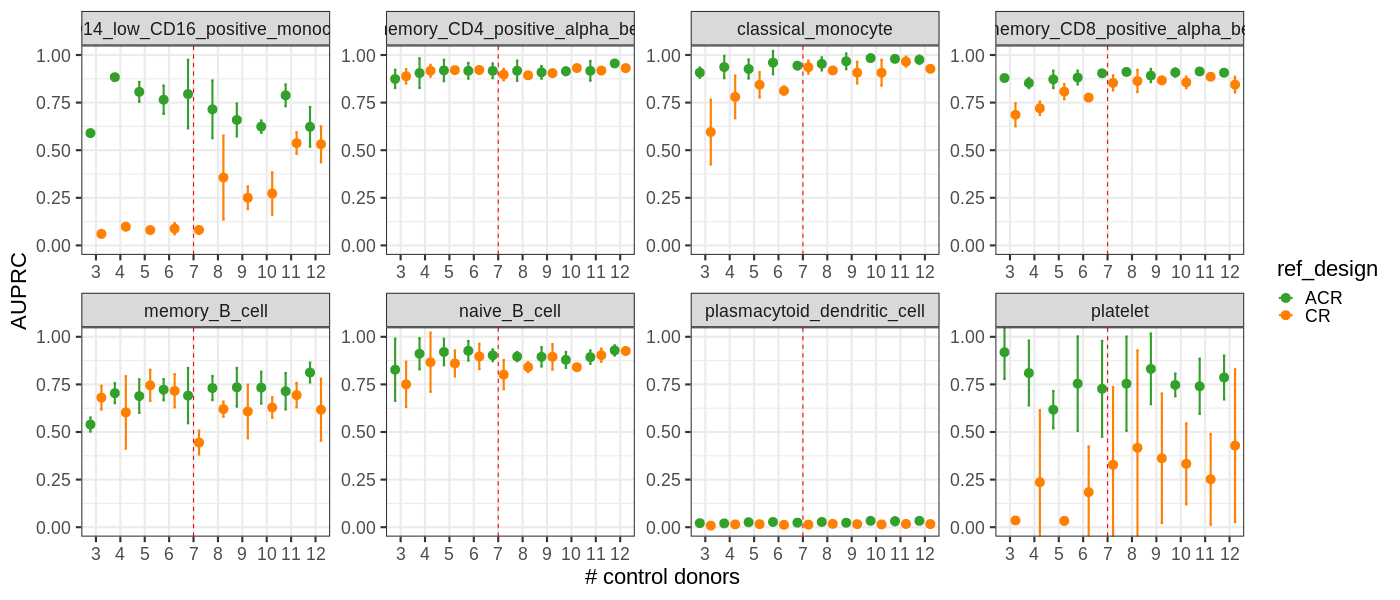

In [164]:
%%R  -h 600 -w 1400
pl_df %>%
# filter(OOR_state == 'platelet') %>%
# select(mean_AUPRC, sd_AUPRC) %>%
mutate(ymax = mean_AUPRC + sd_AUPRC, ymin = mean_AUPRC - sd_AUPRC) %>%
# mutate(ymax = ifelse(ymax > 1, mean_AUPRC, 1),
#        ymin = ifelse(ymin < 0, mean_AUPRC, 0)
#       ) %>%
ggplot(aes(as.factor(n_ctrls), mean_AUPRC, color=ref_design)) +
# #     geom_boxplot() +
    geom_point(size=4, position=position_dodge(width=0.9)) +
    geom_errorbar(aes(ymin=ymin, ymax = ymax), 
                  size=1, width=.2, position=position_dodge(width=0.9)) +
    scale_color_design() +
    theme_bw(base_size=22) +
    coord_cartesian(ylim = c(0,1)) +
    geom_vline(xintercept=max(pl_df$n_ctrls) - 7, linetype=2, color='red') +
    facet_wrap(OOR_state~.,  ncol=4, 
#                labeller = labeller(OOR_state = ct_labeller), 
               scales='free') +
    xlab('# control donors') + ylab("AUPRC")

In [11]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [12]:
def _add_perturb_pop_info(pac_design_adata, perturb_pop, min_perturb_cells = 10):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

# def run_milo(adata_design, query_group, reference_group,
#              sample_col= 'sample_id',
#              annotation_col= 'cell_type',
#              design = '~ is_query'
#              ):
#             milopy.core.make_nhoods(adata_design, prop=0.1)
#             milopy.core.count_nhoods(adata_design, sample_col=sample_col)
#             milopy.utils.annotate_nhoods(
#                 adata_design[adata_design.obs['dataset_group'] == reference_group], annotation_col)
#             adata_design.obs['is_query'] = adata_design.obs['dataset_group'] == query_group
#             milopy.core.DA_nhoods(adata_design, design=design)

In [13]:
cts_oi = ['natural_killer_cell' ,'classical_monocyte' ,'central_memory_CD4_positive_alpha_beta_T_cell','effector_memory_CD8_positive_alpha_beta_T_cell']
dirs = [f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]

In [ ]:
# import warnings 

# nhood_obs_all = pd.DataFrame()
# # with warnings.catch_warnings():
#     # warnings.simplefilter("ignore")
# for d in [outdir + d for d in dirs]:
#     print(f'Parsing {d}')
#     for ctrl_d in os.listdir(d + '/ctrl_size_analysis_nquery5/'):
#         ctrl_sim_dir = d + '/ctrl_size_analysis_nquery5/' + ctrl_d
#         n_ctrls = int(ctrl_sim_dir.split("/")[-1].split('_')[1].strip('size'))
#         sim_seed = int(ctrl_sim_dir.split("/")[-1].split('_')[-1].strip('seed'))

#         perturb_pop = d.split('/')[-1].split('perturb_cell_type')[-1].split('_queryBatch')[0]
#         pac_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PAC_design.h5ad', backed=True)
#         pac_design_adata.obs['dataset_group'] = np.where(pac_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

#         pc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PC_design.h5ad', backed=True)
#         pc_design_adata.obs['dataset_group'] = np.where(pc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')
        
#         jpc_design_adata = sc.read_h5ad(ctrl_sim_dir + '/jointPC_design.h5ad', backed=True)
#         jpc_design_adata.obs['dataset_group'] = np.where(jpc_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

#         run_milo(pc_design_adata, query_group='query', reference_group='ctrl')
#         _add_perturb_pop_info(pc_design_adata, perturb_pop)
        
#         run_milo(jpc_design_adata, query_group='query', reference_group='ctrl')
#         _add_perturb_pop_info(jpc_design_adata, perturb_pop)

#         run_milo(pac_design_adata, query_group='query', reference_group='ctrl')
#         _add_perturb_pop_info(pac_design_adata, perturb_pop)

#         ## Store nhood info
#         des_dict = {'PAC':pac_design_adata, "PC": pc_design_adata, 'joint_PC': jpc_design_adata}
#         for design, adata in des_dict.items():
#             nhood_obs = get_nhood_adata(adata).obs.copy()
#             nhood_obs['design'] = design
#             nhood_obs['perturb_pop'] = perturb_pop
#             nhood_obs['n_ctrls'] = n_ctrls
#             nhood_obs['random_seed'] = sim_seed
#             nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

In [14]:
import warnings 

nhood_obs_all = pd.DataFrame()
# with warnings.catch_warnings():
    # warnings.simplefilter("ignore")
for d in [outdir + d for d in dirs]:
    print(f'Parsing {d}')
    for ctrl_d in os.listdir(d + '/ctrl_size_analysis_nquery5/'):
        ctrl_sim_dir = d + '/ctrl_size_analysis_nquery5/' + ctrl_d
        n_ctrls = int(ctrl_sim_dir.split("/")[-1].split('_')[1].strip('size'))
        sim_seed = int(ctrl_sim_dir.split("/")[-1].split('_')[-1].strip('seed'))

        perturb_pop = d.split('/')[-1].split('perturb_cell_type')[-1].split('_queryBatch')[0]
        pac_design_adata = milopy.utils.read_milo_adata(ctrl_sim_dir + '/PAC_design.h5ad', backed=True)
        pc_design_adata = milopy.utils.read_milo_adata(ctrl_sim_dir + '/PC_design.h5ad', backed=True)
        jpc_design_adata = milopy.utils.read_milo_adata(ctrl_sim_dir + '/jointPC_design.h5ad', backed=True)
        
        _add_perturb_pop_info(pc_design_adata, perturb_pop)
        _add_perturb_pop_info(jpc_design_adata, perturb_pop)
        _add_perturb_pop_info(pac_design_adata, perturb_pop)

        ## Store nhood info
        des_dict = {'PAC':pac_design_adata, "PC": pc_design_adata, 'joint_PC': jpc_design_adata}
        for design, adata in des_dict.items():
            nhood_obs = get_nhood_adata(adata).obs.copy()
            nhood_obs['design'] = design
            nhood_obs['perturb_pop'] = perturb_pop
            nhood_obs['n_ctrls'] = n_ctrls
            nhood_obs['random_seed'] = sim_seed
            nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeclassical_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Parsing /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


In [15]:
nhood_obs_all

,index_cell,kth_distance,nhood_annotation,nhood_annotation_frac,logFC,logCPM,F,PValue,FDR,SpatialFDR,is_perturb_nhood,n_perturb_cells,n_cells,frac_perturb_cells,design,perturb_pop,n_ctrls,random_seed
0,10_1038_s41591_021_01329_2-BGCV04_TACCTATCATGT...,1.494222,central_memory_CD4_positive_alpha_beta_T_cell,0.638889,1.777190,11.172800,2.769306,0.108904,0.496893,0.449089,False,0.0,84.0,0.000000,PAC,natural_killer_cell,9,12345
1,10_1038_s41591_021_01329_2-BGCV04_ACTGTCCAGAAT...,1.308569,central_memory_CD4_positive_alpha_beta_T_cell,0.444444,1.860098,11.626625,1.789910,0.193297,0.669349,0.622446,False,0.0,119.0,0.000000,PAC,natural_killer_cell,9,12345
2,10_1038_s41591_021_01329_2-BGCV04_TCTTCGGTCGAT...,1.021136,effector_memory_CD8_positive_alpha_beta_T_cell,0.928571,4.396090,11.978747,14.641070,0.000800,0.012959,0.010291,True,143.0,161.0,0.888199,PAC,natural_killer_cell,9,12345
3,10_1038_s41591_021_01329_2-BGCV04_ACGAGCCTCCCA...,1.020684,central_memory_CD4_positive_alpha_beta_T_cell,0.536364,0.983495,12.313099,0.525579,0.475380,0.799836,0.773085,False,0.0,208.0,0.000000,PAC,natural_killer_cell,9,12345
4,10_1038_s41591_021_01329_2-BGCV04_CGTCCATGTACT...,1.158482,effector_memory_CD8_positive_alpha_beta_T_cell,0.857143,5.034681,11.545983,22.892651,0.000063,0.004816,0.003784,True,112.0,121.0,0.925620,PAC,natural_killer_cell,9,12345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,10_1038_s41591_021_01329_2-TAGCCGGGTCTCTTAT-MH...,1.727564,classical_monocyte,0.862385,-1.133737,11.131567,1.870689,0.177880,0.569931,0.584459,False,0.0,140.0,0.000000,joint_PC,effector_memory_CD8_positive_alpha_beta_T_cell,12,12345
554,10_1038_s41591_021_01329_2-TGAAAGAAGACATAAC-MH...,2.126876,conventional_dendritic_cell,0.816092,-0.963820,10.903787,1.372153,0.247328,0.675683,0.690081,False,0.0,115.0,0.000000,joint_PC,effector_memory_CD8_positive_alpha_beta_T_cell,12,12345
555,10_1038_s41591_021_01329_2-TAGGCATAGGTGCTTT-MH...,1.736988,classical_monocyte,1.000000,-1.197079,10.930366,2.161203,0.148175,0.546850,0.554226,False,0.0,120.0,0.000000,joint_PC,effector_memory_CD8_positive_alpha_beta_T_cell,12,12345
556,10_1038_s41591_021_01329_2-CTGATAGAGGTTCCTA-MH...,1.682409,mucosal_invariant_T_cell,0.452055,0.489989,10.859657,0.807037,0.373523,0.769098,0.780085,True,44.0,129.0,0.341085,joint_PC,effector_memory_CD8_positive_alpha_beta_T_cell,12,12345


<AxesSubplot:xlabel='logFC', ylabel='frac_perturb_cells'>

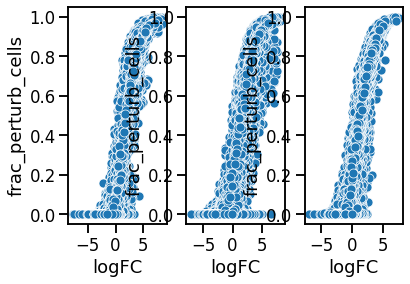

In [16]:
plt.subplot(1,3,1);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'PAC'], x='logFC', y='frac_perturb_cells' );
plt.subplot(1,3,2);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'PC'], x='logFC', y='frac_perturb_cells' )
plt.subplot(1,3,3);
sns.scatterplot(data=nhood_obs_all[nhood_obs_all.design == 'joint_PC'], x='logFC', y='frac_perturb_cells' )

In [17]:
nhood_obs_all.to_csv(outdir + '/ctrl_size_nhood_obs_all_nquery5.csv')

In [15]:
nhood_obs_all = pd.read_csv(outdir + '/ctrl_size_nhood_obs_all_nquery5.csv', index_col=0)

## Compute Area under precision-recall curve

In [18]:
from sklearn.metrics import auc, precision_recall_curve

def _compute_AUPRC(out_df):    
    precision, recall, _ = precision_recall_curve(out_df.is_perturb_nhood, out_df['logFC'])
    no_skill = sum(out_df.is_perturb_nhood) / out_df.shape[0]
    AUC = auc(recall, precision)
    AUPRC_df = pd.DataFrame(np.vstack([recall, precision]), index=['Recall','Precision']).T
    AUPRC_df['AUPRC'] = AUC
    AUPRC_df['no_skill_thresh'] = no_skill
    return(AUPRC_df)


In [19]:
nhood_obs_all['simulation_ID'] = nhood_obs_all.design + "_" + nhood_obs_all.perturb_pop + "_" + nhood_obs_all.n_ctrls.astype('str') + "_" + nhood_obs_all.random_seed.astype('str')

In [20]:
AUPRC_df_all = pd.DataFrame()
for s in nhood_obs_all['simulation_ID'].unique():
    nhood_obs = nhood_obs_all[nhood_obs_all['simulation_ID'] == s]
    AUPRC_df = _compute_AUPRC(nhood_obs)
    AUPRC_df['simulation_ID'] = s
    AUPRC_df['perturb_pop'] = nhood_obs['perturb_pop'][0]
    AUPRC_df['design'] = nhood_obs['design'][0]
    AUPRC_df['n_ctrl'] = nhood_obs['n_ctrls'][0]
    AUPRC_df_all = pd.concat([AUPRC_df_all, AUPRC_df])
AUPRC_df_all = AUPRC_df_all[['AUPRC', 'no_skill_thresh', 'simulation_ID', 'design', 'n_ctrl', 'perturb_pop']].drop_duplicates()

In [21]:
%%R -i AUPRC_df_all
head(AUPRC_df_all)

      AUPRC no_skill_thresh                         simulation_ID   design
1 0.7527924       0.1710214       PAC_natural_killer_cell_9_12345      PAC
2 0.6903451       0.1586345        PC_natural_killer_cell_9_12345       PC
3 0.7303531       0.1781377  joint_PC_natural_killer_cell_9_12345 joint_PC
4 0.7736028       0.1336303      PAC_natural_killer_cell_11_12346      PAC
5 0.5948991       0.1524752       PC_natural_killer_cell_11_12346       PC
6 0.6991517       0.1355599 joint_PC_natural_killer_cell_11_12346 joint_PC
  n_ctrl         perturb_pop
1      9 natural_killer_cell
2      9 natural_killer_cell
3      9 natural_killer_cell
4     11 natural_killer_cell
5     11 natural_killer_cell
6     11 natural_killer_cell


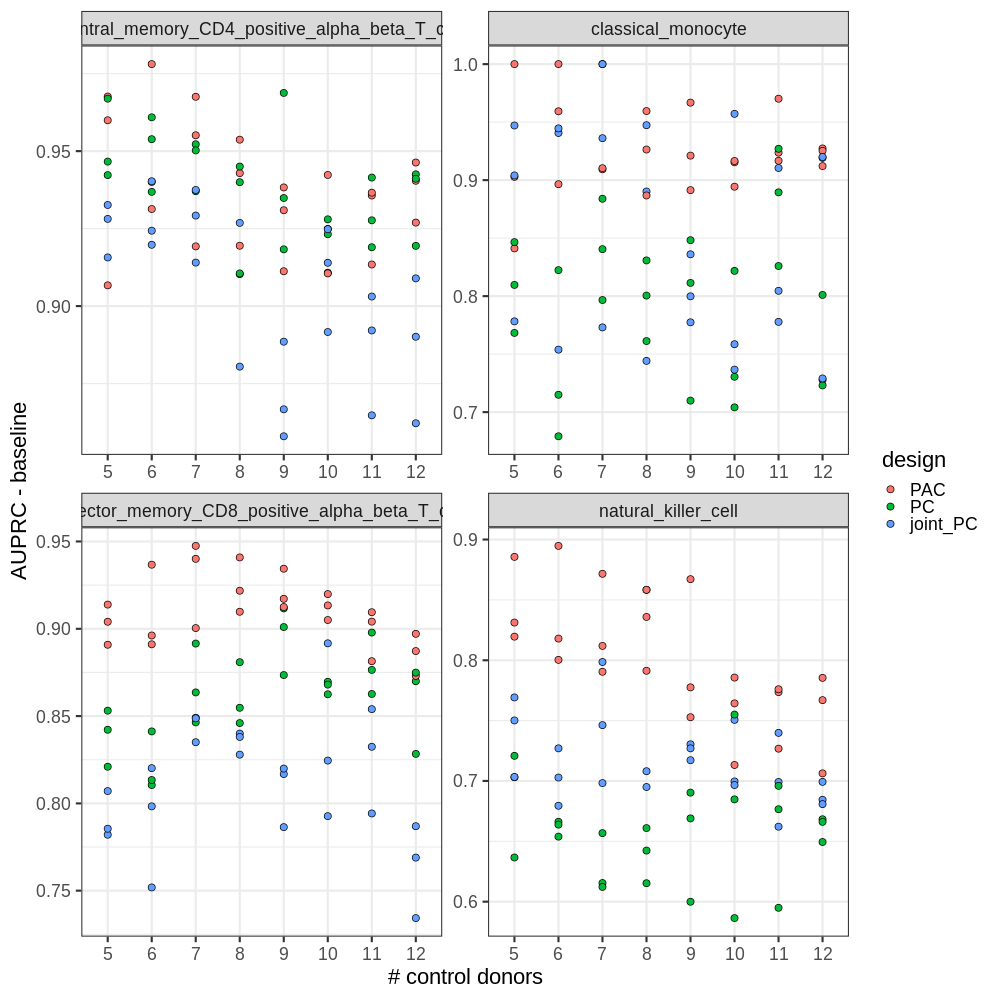

In [30]:
%%R -w 1000 -h 1000
auprc_pl <- AUPRC_df_all %>%
    mutate(design = factor(design, levels=c('PAC', 'PC', 'joint_PC'))) %>%
    ggplot(aes(as.factor(n_ctrl), AUPRC, fill=design)) +
#     geom_boxplot() +
    # geom_line(size=1) +
    geom_point(shape=21, size=3) +
    scale_fill_design() +
    theme_bw(base_size=22) +
    xlab('# control donors') +
    facet_wrap(perturb_pop~., scales='free') +
    ylab('AUPRC - baseline')

auprc_pl

## Compute TPR/FPR

In [23]:
alpha = 0.1
nhood_obs_all['pred_positive'] = (nhood_obs_all.SpatialFDR < alpha) & (nhood_obs_all.logFC > 0)
nhood_obs_all['TP'] = nhood_obs_all['pred_positive'] & (nhood_obs_all['is_perturb_nhood']) & (nhood_obs_all.logFC > 0)
nhood_obs_all['FP'] = nhood_obs_all['pred_positive'] & (~nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['FN'] = (~nhood_obs_all['pred_positive']) & (nhood_obs_all['is_perturb_nhood'])
nhood_obs_all['TN'] = (~nhood_obs_all['pred_positive']) & (~nhood_obs_all['is_perturb_nhood'])

In [24]:
res_all_df = nhood_obs_all.groupby(['design', 'perturb_pop', 'n_ctrls', 'simulation_ID']).sum()[['TP', 'FP', 'FN', "TN"]].reset_index()
res_all_df['TPR'] = res_all_df['TP'] / (res_all_df['TP'] + res_all_df['FN'])
res_all_df['FPR'] = res_all_df['FP'] / (res_all_df['FP'] + res_all_df['TN'])
res_all_df['FDR'] = res_all_df['FP'] / (res_all_df['FP'] + res_all_df['TP'])
res_all_df['Precision'] = res_all_df['TP'] / (res_all_df['FP'] + tpr_df['TP'])
tpr_df['F1'] = ((tpr_df['Precision'] * tpr_df['TPR']) / (tpr_df['Precision'] + tpr_df['TPR'])) * 2
tpr_df.loc[tpr_df['FDR'].isna(), 'FDR'] = 0
tpr_df['design'] = tpr_df['design'].astype('category').cat.reorder_categories(['PAC', "PC", "joint_PC"])
tpr_df

,design,perturb_pop,n_ctrls,simulation_ID,TP,FP,FN,TN,TPR,FPR,FDR,Precision,F1
0,PAC,central_memory_CD4_positive_alpha_beta_T_cell,5,PAC_central_memory_CD4_positive_alpha_beta_T_c...,74,0,65,244,0.532374,0.000000,0.000000,1.000000,0.694836
1,PAC,central_memory_CD4_positive_alpha_beta_T_cell,5,PAC_central_memory_CD4_positive_alpha_beta_T_c...,69,5,75,175,0.479167,0.027778,0.067568,0.932432,0.633028
2,PAC,central_memory_CD4_positive_alpha_beta_T_cell,5,PAC_central_memory_CD4_positive_alpha_beta_T_c...,54,0,84,217,0.391304,0.000000,0.000000,1.000000,0.562500
3,PAC,central_memory_CD4_positive_alpha_beta_T_cell,6,PAC_central_memory_CD4_positive_alpha_beta_T_c...,80,2,69,251,0.536913,0.007905,0.024390,0.975610,0.692641
4,PAC,central_memory_CD4_positive_alpha_beta_T_cell,6,PAC_central_memory_CD4_positive_alpha_beta_T_c...,58,1,82,197,0.414286,0.005051,0.016949,0.983051,0.582915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,joint_PC,natural_killer_cell,11,joint_PC_natural_killer_cell_11_12346,23,0,46,440,0.333333,0.000000,0.000000,1.000000,0.500000
284,joint_PC,natural_killer_cell,11,joint_PC_natural_killer_cell_11_12347,36,0,47,436,0.433735,0.000000,0.000000,1.000000,0.605042
285,joint_PC,natural_killer_cell,12,joint_PC_natural_killer_cell_12_12345,29,0,59,479,0.329545,0.000000,0.000000,1.000000,0.495726
286,joint_PC,natural_killer_cell,12,joint_PC_natural_killer_cell_12_12346,33,0,60,473,0.354839,0.000000,0.000000,1.000000,0.523810


In [45]:
cts_oi



['natural_killer_cell',
 'classical_monocyte',
 'central_memory_CD4_positive_alpha_beta_T_cell',
 'effector_memory_CD8_positive_alpha_beta_T_cell']

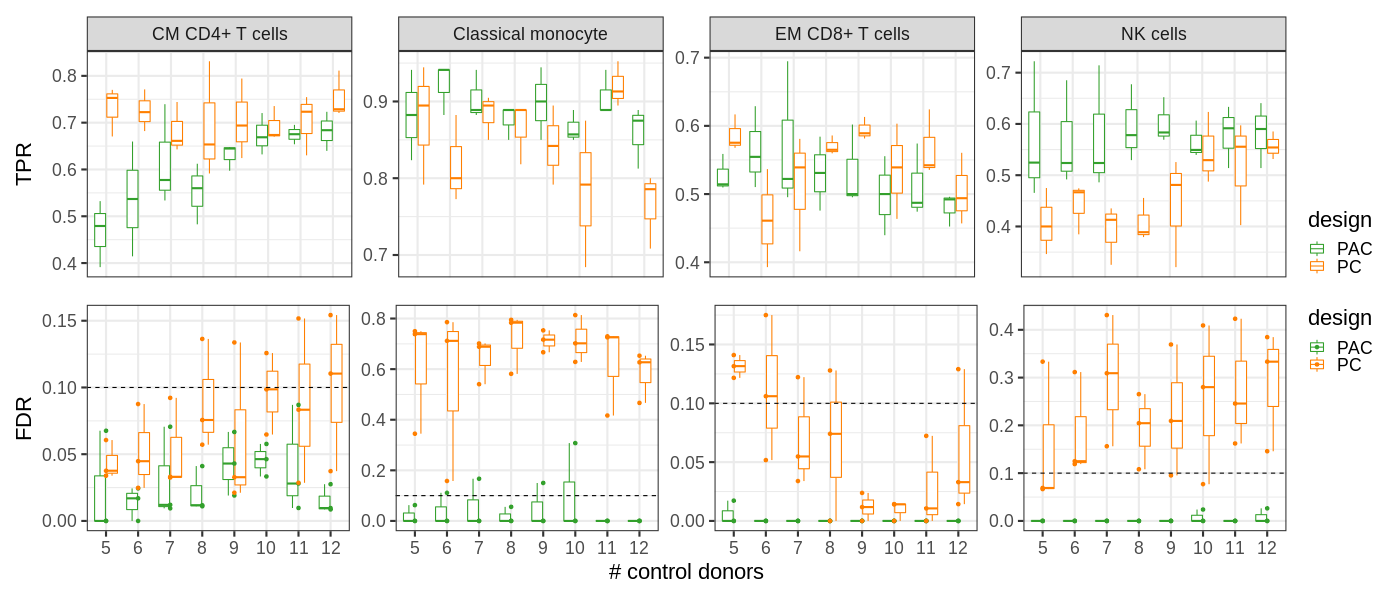

In [60]:
%%R -i tpr_df -h 600 -w 1400 -i figdir

ct_labeller <- c(
     'natural_killer_cell' = 'NK cells',
     'classical_monocyte' = 'Classical monocyte',
    'central_memory_CD4_positive_alpha_beta_T_cell' = 'CM CD4+ T cells',
    'effector_memory_CD8_positive_alpha_beta_T_cell' = 'EM CD8+ T cells'
)

tpr_pl <- tpr_df %>%
filter(design != 'joint_PC') %>%
ggplot(aes(as.factor(n_ctrls), TPR, color=design)) +
    geom_boxplot() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
#     ylim(0,1) +
    facet_wrap(perturb_pop~.,  ncol=4, labeller = labeller(perturb_pop = ct_labeller), scales='free') +
    xlab('# control donors') 

fpr_pl <- tpr_df %>%
    filter(design != 'joint_PC') %>%
    ggplot(aes(as.factor(n_ctrls), FDR, color=design)) +
    geom_boxplot() +
    geom_point() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    # ylim(0,1) +
    geom_hline(yintercept=0.1, linetype=2) +
    facet_wrap(perturb_pop~.,  ncol=4, labeller = labeller(perturb_pop = ct_labeller), scales='free') +
    xlab('# control donors') 

    
((tpr_pl + remove_x_axis()) / 
 fpr_pl + theme(strip.background = element_blank(), strip.text = element_blank())
) +
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'TPR_FPR_boxplots.pdf'), width=14, height=6) +
ggsave(paste0(figdir, 'TPR_FPR_boxplots.png'), width=14, height=6)

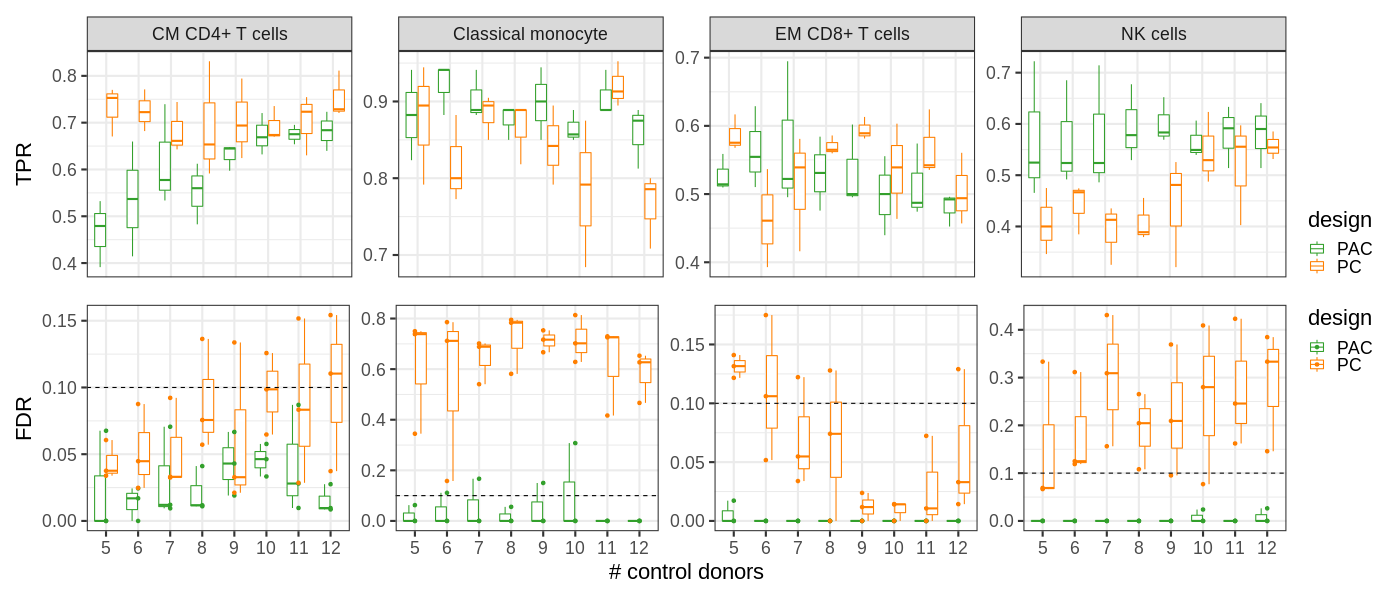

In [60]:
%%R -i tpr_df -h 600 -w 1400 -i figdir

ct_labeller <- c(
     'natural_killer_cell' = 'NK cells',
     'classical_monocyte' = 'Classical monocyte',
    'central_memory_CD4_positive_alpha_beta_T_cell' = 'CM CD4+ T cells',
    'effector_memory_CD8_positive_alpha_beta_T_cell' = 'EM CD8+ T cells'
)

tpr_pl <- tpr_df %>%
filter(design != 'joint_PC') %>%
ggplot(aes(as.factor(n_ctrls), TPR, color=design)) +
    geom_boxplot() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
#     ylim(0,1) +
    facet_wrap(perturb_pop~.,  ncol=4, labeller = labeller(perturb_pop = ct_labeller), scales='free') +
    xlab('# control donors') 

fpr_pl <- tpr_df %>%
    filter(design != 'joint_PC') %>%
    ggplot(aes(as.factor(n_ctrls), FPR, color=design)) +
    geom_boxplot() +
    geom_point() +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
    # ylim(0,1) +
    geom_hline(yintercept=0.1, linetype=2) +
    facet_wrap(perturb_pop~.,  ncol=4, labeller = labeller(perturb_pop = ct_labeller), scales='free') +
    xlab('# control donors') 

    
((tpr_pl + remove_x_axis()) / 
 fpr_pl + theme(strip.background = element_blank(), strip.text = element_blank())
) +
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'TPR_FPR_boxplots.pdf'), width=14, height=6) +
ggsave(paste0(figdir, 'TPR_FPR_boxplots.png'), width=14, height=6)

`summarise()` has grouped output by 'design', 'perturb_pop'. You can override using the `.groups` argument.


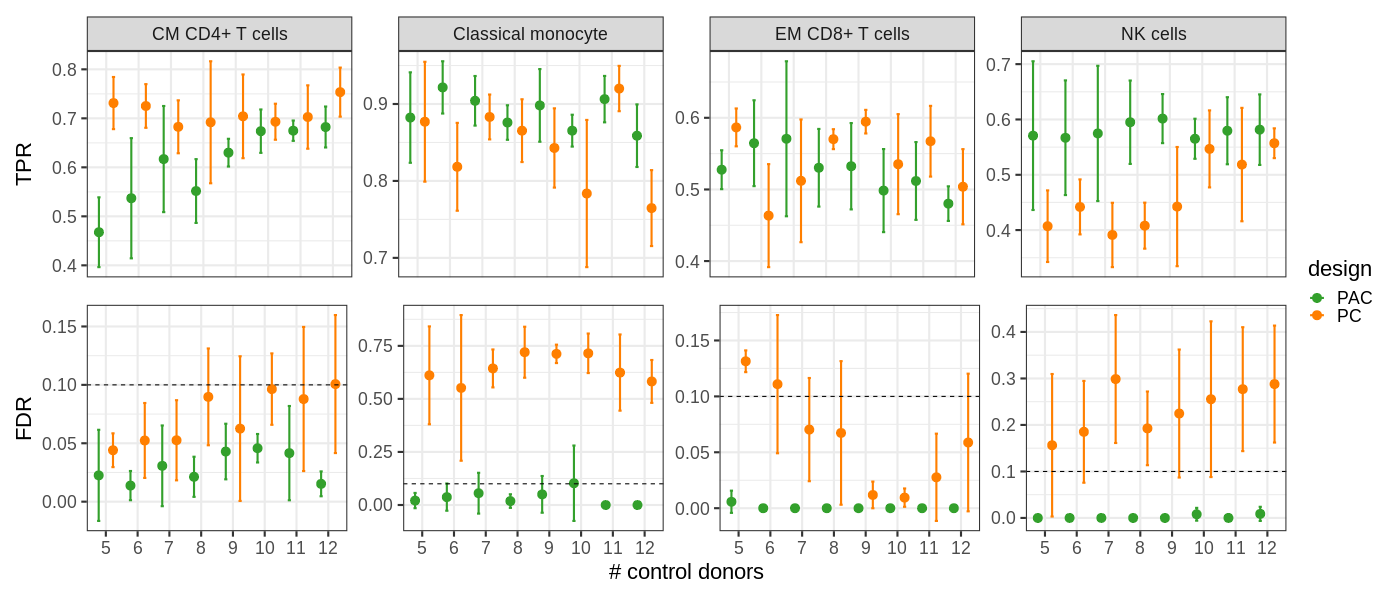

In [73]:
%%R -i tpr_df -h 600 -w 1400 -i figdir

ct_labeller <- c(
     'natural_killer_cell' = 'NK cells',
     'classical_monocyte' = 'Classical monocyte',
    'central_memory_CD4_positive_alpha_beta_T_cell' = 'CM CD4+ T cells',
    'effector_memory_CD8_positive_alpha_beta_T_cell' = 'EM CD8+ T cells'
)

pl_df <- tpr_df %>%
    filter(design != 'joint_PC') %>%
    group_by(design, perturb_pop, n_ctrls) %>%
    summarise(mean_TPR=mean(TPR), mean_FPR=mean(FPR), mean_FDR=mean(FDR),
              sd_TPR = sd(TPR), sd_FPR = sd(FPR), sd_FDR = sd(FDR))
    
tpr_pl <- pl_df %>%
    ggplot(aes(as.factor(n_ctrls), mean_TPR, color=design)) +
    geom_point(size=4, position=position_dodge(width=0.9)) +
    geom_errorbar(aes(ymin=mean_TPR - sd_TPR, ymax = mean_TPR + sd_TPR), 
                  size=1, width=.2, position=position_dodge(width=0.9)) +
    # geom_line(size=1) +
    scale_color_design() +
    theme_bw(base_size=22) +
#     ylim(0,1) +
    facet_wrap(perturb_pop~.,  ncol=4, labeller = labeller(perturb_pop = ct_labeller), scales='free') +
    xlab('# control donors') + ylab("TPR")

fpr_pl <-pl_df %>%
    ggplot(aes(as.factor(n_ctrls), mean_FDR, color=design)) +
    geom_point(size=4, position=position_dodge(width=0.9)) +
    geom_errorbar(aes(ymin=mean_FDR - sd_FDR, ymax = mean_FDR + sd_FDR), 
                  size=1, width=.2, position=position_dodge(width=0.9)) +
    scale_color_design() +
    theme_bw(base_size=22) +
    # ylim(0,1) +
    geom_hline(yintercept=0.1, linetype=2) +
    facet_wrap(perturb_pop~.,  ncol=4, labeller = labeller(perturb_pop = ct_labeller), scales='free') +
    xlab('# control donors') + ylab("FDR")

    
((tpr_pl + remove_x_axis()) / 
 fpr_pl + theme(strip.background = element_blank(), strip.text = element_blank())
) +
plot_layout(guides='collect') +
ggsave(paste0(figdir, 'TPR_FDR_pointplots.pdf'), width=14, height=6) +
ggsave(paste0(figdir, 'TPR_FDR_pointplots.png'), width=14, height=6)

`summarise()` has grouped output by 'design'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'design'. You can override using the `.groups` argument.


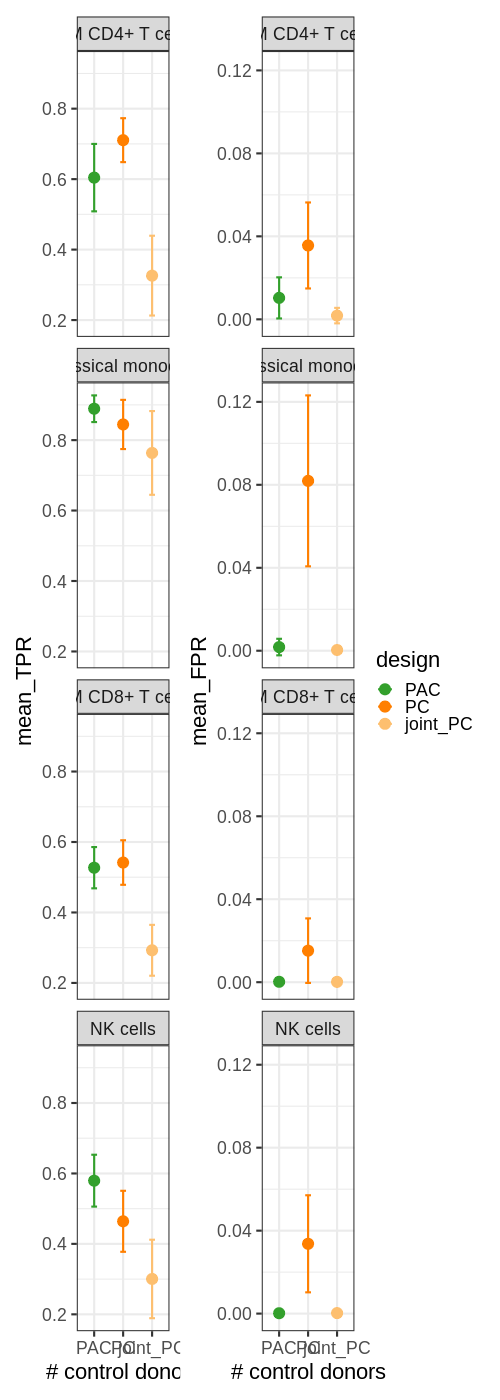

In [49]:
%%R -i tpr_df -w 500 -h 1400
tpr_pl <- tpr_df %>%
    group_by(design, perturb_pop) %>%
    summarise(mean_TPR=mean(TPR), mean_FPR=mean(FPR),
              sd_TPR = sd(TPR), sd_FPR = sd(FPR)) %>%
    ggplot(aes(design, mean_TPR, color=design)) +
    geom_point(size=5) +
    geom_errorbar(aes(ymin=mean_TPR - sd_TPR, ymax = mean_TPR + sd_TPR), 
                  size=1, width=.2) +
    scale_color_design() +
    theme_bw(base_size=22) +
    facet_wrap(perturb_pop~.,  ncol=1, labeller = labeller(perturb_pop = ct_labeller)) +
    xlab('# control donors') 

fpr_pl <- tpr_df %>%
    group_by(design, perturb_pop) %>%
    summarise(mean_TPR=mean(TPR), mean_FPR=mean(FPR),
              sd_TPR = sd(TPR), sd_FPR = sd(FPR)) %>%
    ggplot(aes(design, mean_FPR, color=design)) +
    geom_point(size=5) +
    geom_errorbar(aes(ymin=mean_FPR - sd_FPR, ymax = mean_FPR + sd_FPR), 
                  size=1, width=.2) +
    scale_color_design() +
    theme_bw(base_size=22) +
    # ylim(0,1) +
    facet_wrap(perturb_pop~.,  ncol=1, labeller = labeller(perturb_pop = ct_labeller)) +
    xlab('# control donors') 

    
(tpr_pl + fpr_pl) +
plot_layout(guides='collect')

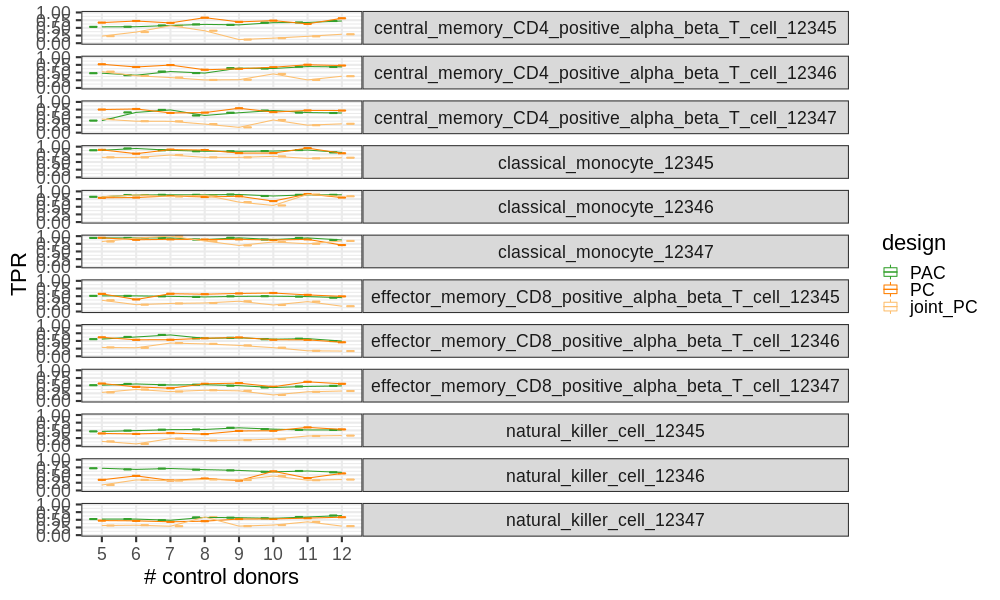

In [26]:
%%R -w 1000 -h 600
tpr_df %>%
    # filter(str_detect(simulation_ID, '12347$')) %>%
    filter(perturb_pop != 'naive_B_cell') %>%
    mutate(group_ID = paste( perturb_pop, str_remove(simulation_ID, '.+_'), sep='_')) %>%
    group_by(n_ctrls, design, perturb_pop) %>%
    mutate(mean_TPR = mean(TPR), mean_FPR = mean(FPR), mean_FDR = mean(FDR), mean_precision=mean(Precision)) %>%
    ungroup() %>%
    ggplot(aes(as.factor(n_ctrls), TPR, color=design)) +
    geom_boxplot() +
    # geom_point() +
    geom_line(aes(group=design), size=0.5) +
    scale_color_design() +
    theme_bw(base_size=22) +
    ylim(0,1) +
    facet_grid(group_ID~., scales='free') +
    xlab('# control donors') +
    theme(strip.text.y=element_text(angle=0))

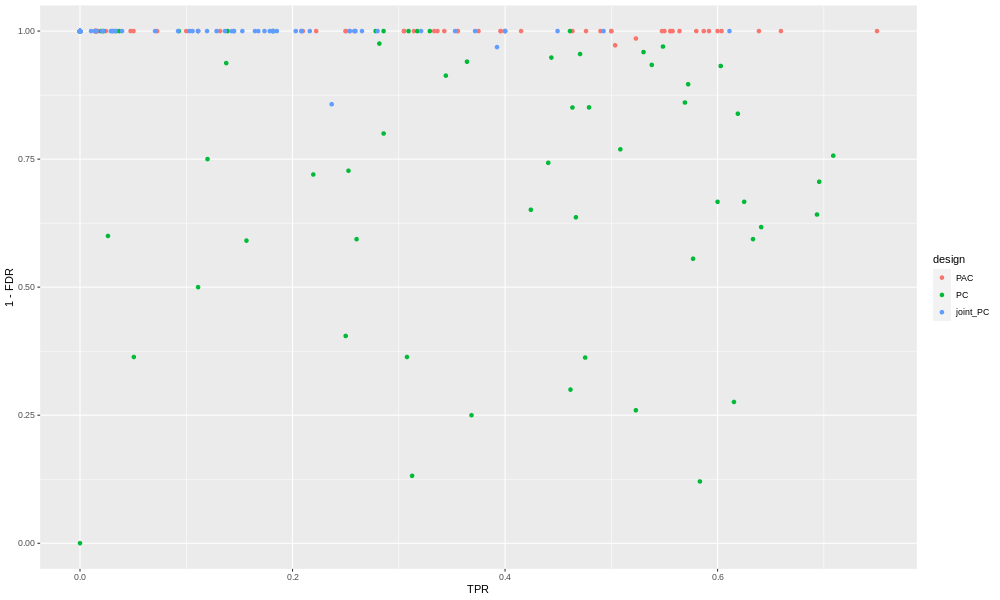

In [73]:
%%R -w 1000 -h 600
tpr_df %>%
    # filter(str_detect(simulation_ID, '12347$')) %>%
    filter(perturb_pop != 'naive_B_cell') %>%
    mutate(group_ID = paste( perturb_pop, str_remove(simulation_ID, '.+_'), sep='_')) %>%
    group_by(n_ctrls, design, perturb_pop) %>%
    mutate(mean_TPR = mean(TPR), mean_FPR = mean(FPR), mean_FDR = mean(FDR), mean_precision=mean(Precision)) %>%
    ungroup() %>%
    ggplot(aes( TPR, 1 - FDR, color=design)) +
    geom_point()

In [148]:
d = dirs[4]

In [149]:
d

'qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

In [150]:
## Check what's wrong with seed 12345
ctrl_sim_dir = outdir+ d + '/ctrl_size_analysis_nquery5/' + 'ctrl_size9_seed12345'
n_ctrls = int(ctrl_sim_dir.split("/")[-1].split('_')[1].strip('size'))
sim_seed = int(ctrl_sim_dir.split("/")[-1].split('_')[-1].strip('seed'))

perturb_pop = d.split('/')[-1].split('perturb_cell_type')[-1].split('_queryBatch')[0]
pac_design_adata = sc.read_h5ad(ctrl_sim_dir + '/PAC_design.h5ad', backed=True)
pac_design_adata.obs['dataset_group'] = np.where(pac_design_adata.obs['is_test'] == 1, 'query', 'ctrl')

In [151]:
pac_design_adata.obs[pac_design_adata.obs['cell_type'] == 'effector_memory_CD8_positive_alpha_beta_T_cell'][['donor_id', 'dataset_group']].value_counts()

donor_id   dataset_group
MH8919230  query            93
MH8919231  query            75
MH8919282  query            50
CV0904     query            44
CV0926     query            19
dtype: int64

In [159]:
adata_query = sc.read_h5ad(outdir+d + '/query.h5ad')

In [166]:
query_donors = adata_query.obs['donor_id'].unique()

perturb_pop = 'naive_B_cell'
n_querys = 5
## Select n donors with most cells in query_specific population
sample_querys = adata_query.obs[adata_query.obs['cell_type' ] == perturb_pop].value_counts('donor_id')[0:n_querys].index.values

['MH8919278', 'MH8919231', 'MH8919230', 'CV0944', 'MH8919280']
Categories (16, object): ['CV0904', 'CV0911', 'CV0917', 'CV0926', ..., 'MH8919283', 'MH8919332', 'newcastle65', 'newcastle74']

In [152]:
sc.tl.umap(pac_design_adata)

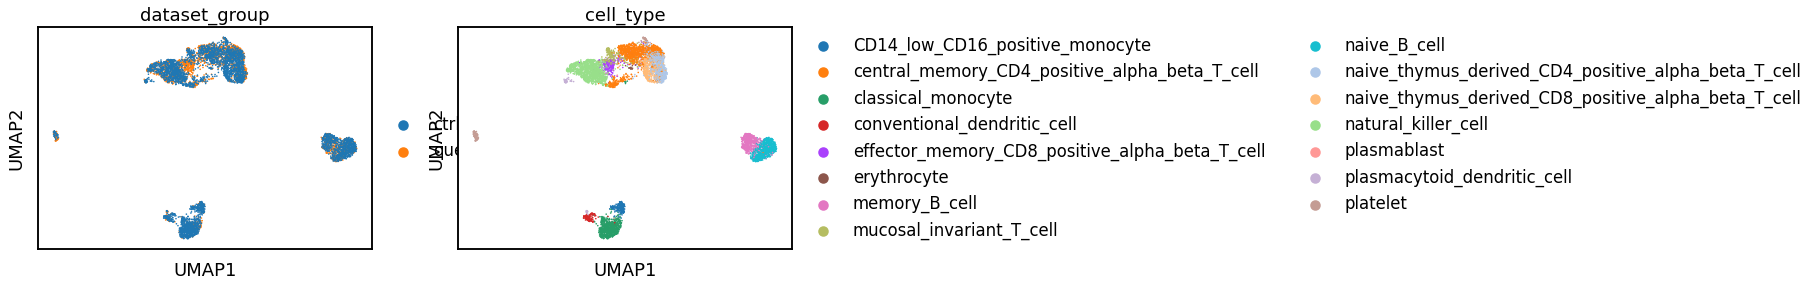

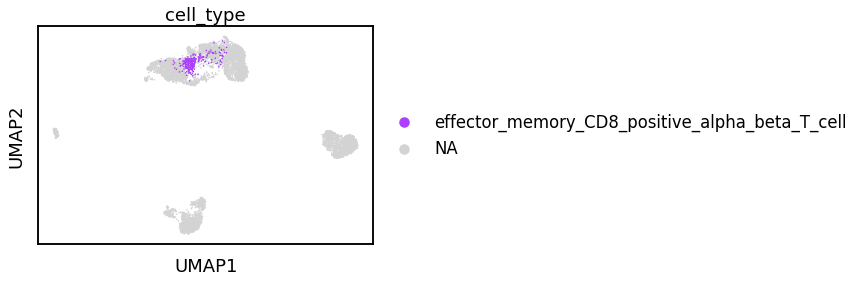

In [157]:
sc.pl.umap(pac_design_adata, color=['dataset_group', 'cell_type'], size=10, ncols=3)
sc.pl.umap(pac_design_adata, color=['cell_type'], size=10, ncols=3, groups='effector_memory_CD8_positive_alpha_beta_T_cell')

In [154]:
run_milo(pac_design_adata, query_group='query', reference_group='ctrl')
_add_perturb_pop_info(pac_design_adata, perturb_pop)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [155]:
milopy.utils.build_nhood_graph(pac_design_adata)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


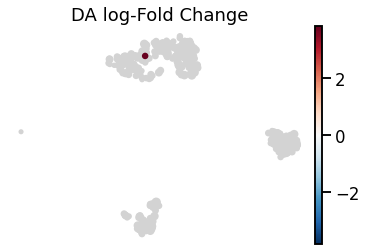

In [156]:
milopy.plot.plot_nhood_graph(pac_design_adata, min_size=1, alpha=0.1)

In [114]:
get_nhood_adata(pac_design_adata).obs["PValue"]

0      0.429456
1      0.438650
2      0.353990
3      0.921013
4      0.794218
         ...   
403    0.157226
404    0.624565
405    0.708315
406    0.660897
407    0.381382
Name: PValue, Length: 408, dtype: float64

In [121]:
sc.pp.neighbors(pac_design_adata, n_neighbors=30, use_rep='X_scVI')